In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, accuracy_score
import os
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import plotly.express as px


In [33]:
train_dir = './data/train'
valid_dir = './data/valid'
test_dir = './data/test'


train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


In [34]:
class_names = sorted(os.listdir(train_dir))
n_classes = len(class_names)

print(f"Total number of classes: {n_classes}")
print(f"Classes: {class_names}")


Total number of classes: 5
Classes: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']


In [35]:
class_dis = [len(os.listdir(os.path.join(train_dir, name))) for name in class_names]

pie_chart = px.pie(values=class_dis, names=class_names, color=class_names)
pie_chart.update_layout({'title':{'text':"Class Distribution"}})
pie_chart.show()

bar_chart = px.bar(y=class_dis, x=class_names, color=class_names)
bar_chart.show()

# Display a few sample images from the dataset


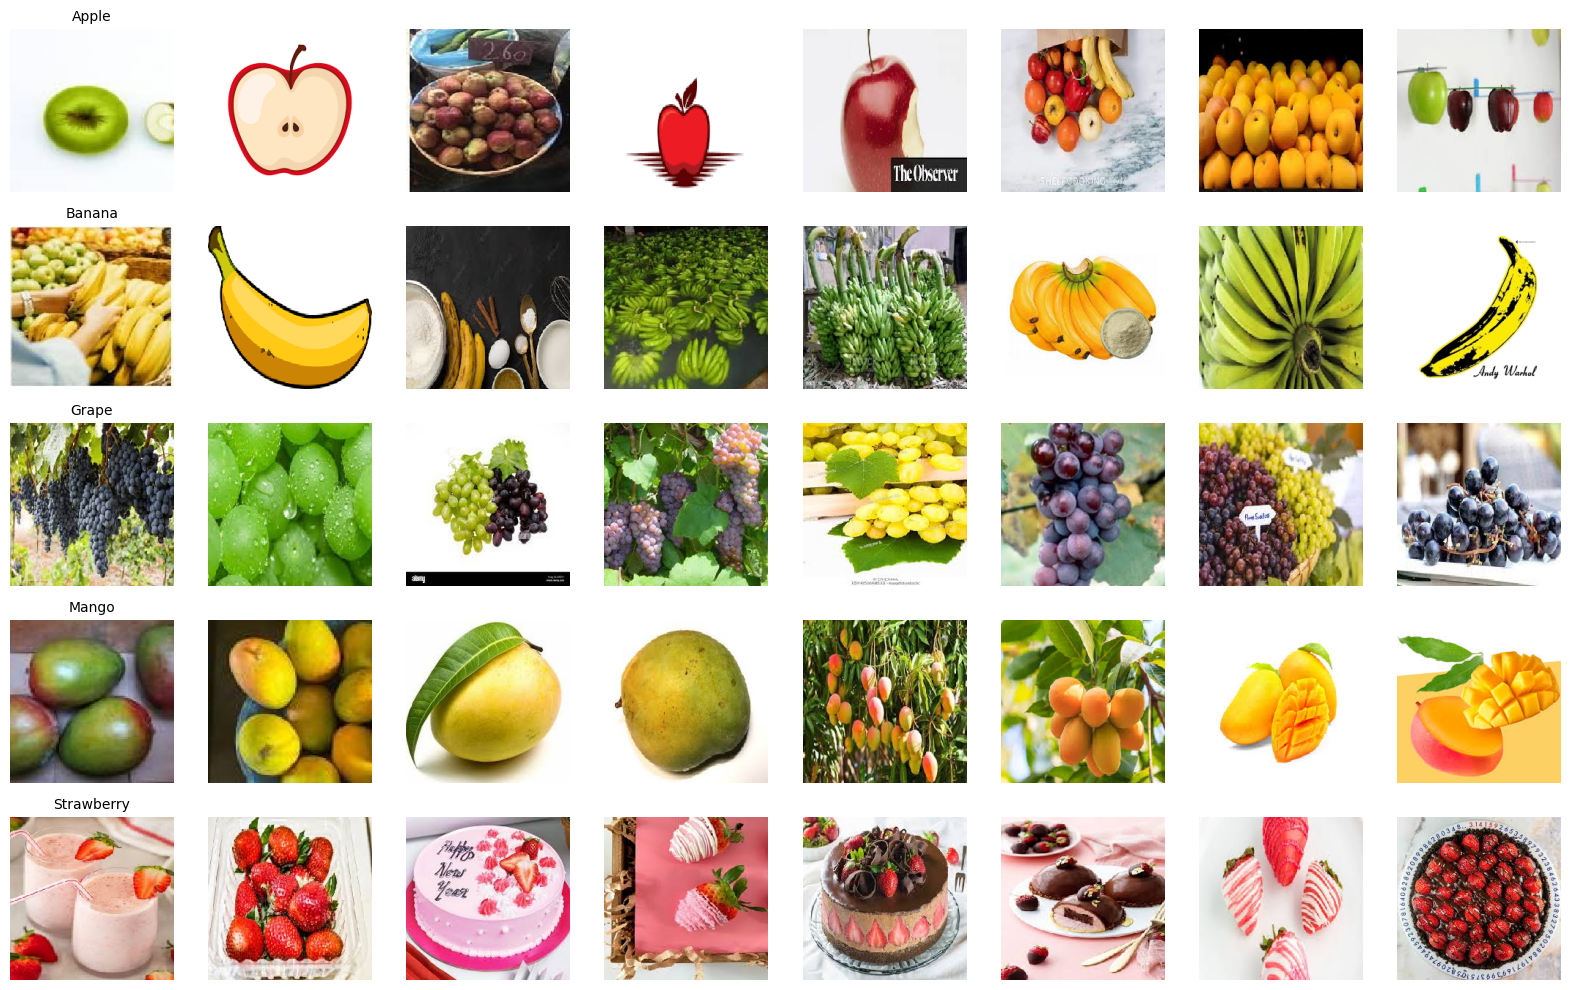

In [57]:
def display_sample_images(train_dir, class_names, n_images=5):
    fig, axes = plt.subplots(len(class_names), n_images, figsize=(n_images * 2, len(class_names) * 2))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        images = os.listdir(class_path)[:n_images]
        for j, img_name in enumerate(images):
            img_path = os.path.join(class_path, img_name)
            img = image.load_img(img_path, target_size=(224, 224))
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            if j == 0:
                ax.set_title(class_name, fontsize=10)
    plt.tight_layout()
    plt.show()

display_sample_images(train_dir, class_names, n_images=8)

# Load the MobileNetV2 model pre-trained on ImageNet, excluding the top layer


In [37]:
base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))


In [38]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


Found 9700 images belonging to 5 classes.
Found 200 images belonging to 5 classes.
Found 100 images belonging to 5 classes.


# Extract features from the dataset using the pre-trained model


In [39]:
def extract_features(generator, model):
    features = model.predict(generator)
    labels = generator.classes
    return features, labels

train_features, train_labels = extract_features(train_generator, base_model)
valid_features, valid_labels = extract_features(valid_generator, base_model)
test_features, test_labels = extract_features(test_generator, base_model)


4/4 [==============================] - 1s 113ms/step


In [40]:
print(train_features.shape, valid_features.shape, test_features.shape)

(9700, 1280) (200, 1280) (100, 1280)


In [41]:
print(train_labels.shape, valid_labels.shape, test_labels.shape)

(9700,) (200,) (100,)


# SVM model

In [42]:
from sklearn.svm import SVC

svm_model = SVC(kernel="linear", C=0.0025)
svm_model.fit(train_features, train_labels)
svm_predicitions_valid = svm_model.predict(valid_features)

print(classification_report(valid_labels, svm_predicitions_valid))
print('Accuracy valid:',accuracy_score(valid_labels, svm_predicitions_valid))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        40
           1       0.88      0.93      0.90        40
           2       0.82      0.82      0.82        40
           3       0.95      0.90      0.92        40
           4       0.93      0.93      0.93        40

    accuracy                           0.88       200
   macro avg       0.88      0.88      0.88       200
weighted avg       0.88      0.88      0.88       200

Accuracy valid: 0.875


In [43]:
svm_predicitions_test = svm_model.predict(test_features)
print(classification_report(test_labels, svm_predicitions_test))
print('Accuracy test:',accuracy_score(test_labels, svm_predicitions_test))

              precision    recall  f1-score   support

           0       0.70      0.80      0.74        20
           1       0.90      0.95      0.93        20
           2       0.94      0.85      0.89        20
           3       0.80      0.80      0.80        20
           4       0.94      0.85      0.89        20

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

Accuracy test: 0.85


# RandomForest model

In [44]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=1000, random_state=42)

rf_model.fit(train_features, train_labels)
rf_predictions_valid = rf_model.predict(valid_features)

print(classification_report(valid_labels, rf_predictions_valid))
print('Accuracy valid:',accuracy_score(valid_labels, rf_predictions_valid))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74        40
           1       0.90      0.95      0.93        40
           2       0.82      0.70      0.76        40
           3       0.88      0.88      0.88        40
           4       0.86      0.93      0.89        40

    accuracy                           0.84       200
   macro avg       0.84      0.84      0.84       200
weighted avg       0.84      0.84      0.84       200

Accuracy valid: 0.84


In [45]:
rf_predictions_test = rf_model.predict(test_features)
print(classification_report(test_labels, rf_predictions_test))
print('Accuracy test:',accuracy_score(test_labels, rf_predictions_test))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.80      1.00      0.89        20
           2       0.89      0.85      0.87        20
           3       0.89      0.80      0.84        20
           4       0.94      0.80      0.86        20

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

Accuracy test: 0.84


# LogisticRegression model

In [46]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(train_features, train_labels)
lr_predictions = lr_model.predict(test_features)
print(classification_report(test_labels, lr_predictions))
print('Accuracy:', accuracy_score(test_labels, lr_predictions))


              precision    recall  f1-score   support

           0       0.70      0.70      0.70        20
           1       0.90      0.90      0.90        20
           2       0.90      0.90      0.90        20
           3       0.71      0.75      0.73        20
           4       0.89      0.85      0.87        20

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

Accuracy: 0.82


# Xgboost model

In [47]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=10)
xgb_model.fit(train_features, train_labels)

xgb_predictions_valid = xgb_model.predict(valid_features)
print(classification_report(valid_labels, xgb_predictions_valid))
print('Accuracy valid:', accuracy_score(valid_labels, xgb_predictions_valid))

              precision    recall  f1-score   support

           0       0.83      0.85      0.84        40
           1       0.84      0.93      0.88        40
           2       0.82      0.80      0.81        40
           3       1.00      0.93      0.96        40
           4       0.97      0.95      0.96        40

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200

Accuracy valid: 0.89


In [48]:
xgb_predictions_test = xgb_model.predict(test_features)

print(classification_report(test_labels, xgb_predictions_test))
print('Accuracy test:', accuracy_score(test_labels, xgb_predictions_test))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79        20
           1       0.95      1.00      0.98        20
           2       0.95      0.90      0.92        20
           3       0.94      0.80      0.86        20
           4       0.90      0.90      0.90        20

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100

Accuracy test: 0.89


# Lightgbm model

In [49]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier()
lgb_model.fit(train_features, train_labels)

lgb_predictions_valid = lgb_model.predict(valid_features)
print(classification_report(valid_labels, lgb_predictions_valid))
print('Accuracy valid:', accuracy_score(valid_labels, lgb_predictions_valid))

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.086210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 9700, number of used features: 1280
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
              precision    recall  f1-score   support

           0       0.84      0.80      0.82        40
           1       0.91      0.97      0.94        40
           2       0.85      0.85      0.85        40
           3       0.90      0.90      0.90        40
           4       0.97      0.95      0.96        40

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weig

In [50]:
lgb_predictions_test = lgb_model.predict(test_features)
print(classification_report(test_labels, lgb_predictions_test))
print('Accuracy test:', accuracy_score(test_labels, lgb_predictions_test))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73        20
           1       0.87      1.00      0.93        20
           2       0.89      0.85      0.87        20
           3       0.89      0.80      0.84        20
           4       0.95      0.90      0.92        20

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

Accuracy test: 0.86


# predict image

1/1 [==============================] - 0s 43ms/step
{'Apple': 0, 'Banana': 1, 'Grape': 2, 'Mango': 3, 'Strawberry': 4}
[0]


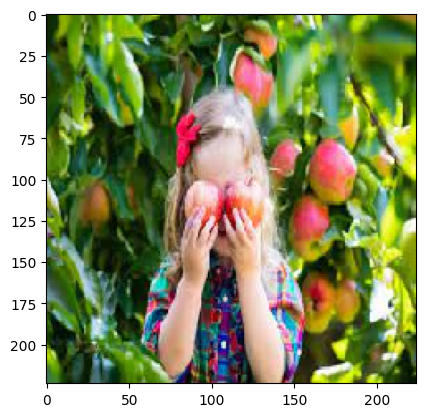

In [56]:
def predict_image(img_path, model,base_model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    features = base_model.predict(img_array)
    predictions = model.predict(features)
    print(test_generator.class_indices)
    print(predictions)
    
    plt.imshow(img)
    plt.show()
    
predict_image('./data/test/Apple/Apple (420).jpeg', lgb_model,base_model)
    

# END